In [331]:
import numpy as np 
import pandas as pd 

import json
from pandas.io.json import json_normalize
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import explained_variance_score, roc_auc_score, precision_recall_curve, roc_curve, average_precision_score,accuracy_score
from sklearn import model_selection, preprocessing, metrics
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score, cross_validate
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import plotly.plotly as py #For World Map
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from mpl_toolkits.basemap import Basemap

import gc
import os
print(os.listdir("."))

['.DS_Store', 'Untitled.ipynb', 'baseline_lgb.csv', 'test.csv', 'train-flattened.csv', 'test-flattened.csv', 'google-analytics-customer-revenue-prediction.ipynb', 'train.csv', '.ipynb_checkpoints', 'sample_submission.csv']


In [332]:
#Reference: https://www.kaggle.com/julian3833/1-quick-start-read-csv-and-flatten-json-fields/notebook
def load_df(csv_path, low_memory=False, nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    df = pd.read_csv(csv_path, converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'},
                         nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df



In [333]:

#train = load_df('./train.csv')
#test = load_df('./test.csv')


In [334]:

#train.info()


In [335]:

train_flat = pd.read_csv("train-flattened.csv", low_memory=False, nrows=None) #nrows=903653
test_flat = pd.read_csv("test-flattened.csv", low_memory=False, nrows=None) #nrows=804684


In [336]:
train_flat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 55 columns):
channelGrouping                                      903653 non-null object
date                                                 903653 non-null int64
fullVisitorId                                        903653 non-null object
sessionId                                            903653 non-null object
socialEngagementType                                 903653 non-null object
visitId                                              903653 non-null int64
visitNumber                                          903653 non-null int64
visitStartTime                                       903653 non-null int64
device.browser                                       903653 non-null object
device.browserSize                                   903653 non-null object
device.browserVersion                                903653 non-null object
device.deviceCategory                                9036

In [337]:
#train.to_csv("train-flattened.csv", index=False)
#test.to_csv("test-flattened.csv", index=False)
#train_flat['channelGrouping'].unique()
#train_flat.head(100)

#print(train_flat['trafficSource.campaign'].unique())
#print(train_flat['trafficSource.campaignCode'].unique())
train_flat.head(10)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserSize,...,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.campaign,trafficSource.campaignCode,trafficSource.isTrueDirect,trafficSource.keyword,trafficSource.medium,trafficSource.referralPath,trafficSource.source
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,google + online,organic,NaN,google
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,Not Socially Engaged,1472822600,2,1472822600,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,True,(not provided),organic,NaN,google
5,Organic Search,20160902,2938943183656635653,2938943183656635653_1472807194,Not Socially Engaged,1472807194,1,1472807194,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
6,Organic Search,20160902,1905672039242460897,1905672039242460897_1472817241,Not Socially Engaged,1472817241,1,1472817241,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
7,Organic Search,20160902,537222803633850821,537222803633850821_1472812602,Not Socially Engaged,1472812602,1,1472812602,Chrome,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
8,Organic Search,20160902,4445454811831400414,4445454811831400414_1472805784,Not Socially Engaged,1472805784,1,1472805784,Internet Explorer,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google
9,Organic Search,20160902,9499785259412240342,9499785259412240342_1472812272,Not Socially Engaged,1472812272,1,1472812272,Firefox,not available in demo dataset,...,NaN,NaN,NaN,(not set),NaN,NaN,(not provided),organic,NaN,google


In [338]:
train_flat.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
date,903653.0,2.016589e+07,4.697698e+03,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
visitId,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09
visitNumber,903653.0,2.264897e+00,9.283735e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.950000e+02
visitStartTime,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09
totals.bounces,450630.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
totals.hits,903653.0,4.596538e+00,9.641437e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+02
totals.newVisits,703060.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
totals.pageviews,903553.0,3.849764e+00,7.025274e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,4.690000e+02
totals.transactionRevenue,11515.0,1.337448e+08,4.482852e+08,1.000000e+04,2.493000e+07,4.945000e+07,1.076550e+08,2.312950e+10
totals.visits,903653.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [339]:

train_flat['totals.transactionRevenue'].fillna(0,inplace=True)

def repace_nan_with_zero(cols):
    for col in cols:
        train_flat[col].fillna(0,inplace=True)
        test_flat[col].fillna(0,inplace=True)
    
cols = ['trafficSource.adwordsClickInfo.page', 'trafficSource.isTrueDirect', 'totals.newVisits', 
        'totals.bounces', 'trafficSource.adwordsClickInfo.isVideoAd', 'totals.pageviews']
repace_nan_with_zero(cols);  

train_flat.describe().transpose()


,count,mean,std,min,25%,50%,75%,max
date,903653.0,2.016589e+07,4.697698e+03,2.016080e+07,2.016103e+07,2.017011e+07,2.017042e+07,2.017080e+07
visitId,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09
visitNumber,903653.0,2.264897e+00,9.283735e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.950000e+02
visitStartTime,903653.0,1.485007e+09,9.022124e+06,1.470035e+09,1.477561e+09,1.483949e+09,1.492759e+09,1.501657e+09
totals.bounces,903653.0,4.986759e-01,4.999985e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
totals.hits,903653.0,4.596538e+00,9.641437e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,5.000000e+02
totals.newVisits,903653.0,7.780199e-01,4.155781e-01,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
totals.pageviews,903653.0,3.849338e+00,7.025002e+00,0.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,4.690000e+02
totals.transactionRevenue,903653.0,1.704273e+06,5.277866e+07,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.312950e+10
totals.visits,903653.0,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [340]:
train_flat['totals.transactionRevenueLog'] =  np.log1p(train_flat['totals.transactionRevenue'])

train_flat['totals.transactionRevenueLogNAN'] =  np.log1p(train_flat['totals.transactionRevenue'])
train_flat['totals.transactionRevenueLogNAN'].replace(0,np.nan,inplace=True)

In [341]:
train_flat.isna().sum()

channelGrouping                                           0
date                                                      0
fullVisitorId                                             0
sessionId                                                 0
socialEngagementType                                      0
visitId                                                   0
visitNumber                                               0
visitStartTime                                            0
device.browser                                            0
device.browserSize                                        0
device.browserVersion                                     0
device.deviceCategory                                     0
device.flashVersion                                       0
device.isMobile                                           0
device.language                                           0
device.mobileDeviceBranding                               0
device.mobileDeviceInfo                 

In [342]:
train_flat.count()

channelGrouping                                      903653
date                                                 903653
fullVisitorId                                        903653
sessionId                                            903653
socialEngagementType                                 903653
visitId                                              903653
visitNumber                                          903653
visitStartTime                                       903653
device.browser                                       903653
device.browserSize                                   903653
device.browserVersion                                903653
device.deviceCategory                                903653
device.flashVersion                                  903653
device.isMobile                                      903653
device.language                                      903653
device.mobileDeviceBranding                          903653
device.mobileDeviceInfo                 

In [343]:
#drop columns containing more than 80% Nan values

cols_to_drop_from_train_only = ['trafficSource.campaignCode']

cols_to_drop = ['trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 
               'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.slot', 
               'trafficSource.keyword', 'trafficSource.referralPath', 
               'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation',
               'device.screenResolution', 'device.screenColors', 'device.operatingSystemVersion',
               'device.mobileInputSelector', 'device.mobileDeviceModel', 'device.mobileDeviceMarketingName',
               'device.mobileDeviceInfo', 'device.mobileDeviceBranding','device.language', 'device.flashVersion',
               'device.browserVersion', 'device.browserSize', 'trafficSource.adwordsClickInfo.criteriaParameters', 
               'geoNetwork.cityId', 'socialEngagementType', 'sessionId', 'geoNetwork.city', 'geoNetwork.metro',
               'totals.visits']


train_flat.count()

train_flat = train_flat.drop(columns=cols_to_drop)
train_flat = train_flat.drop(columns=cols_to_drop_from_train_only)

test_flat = test_flat.drop(columns=cols_to_drop)

train_flat.isna().sum()

channelGrouping                                  0
date                                             0
fullVisitorId                                    0
visitId                                          0
visitNumber                                      0
visitStartTime                                   0
device.browser                                   0
device.deviceCategory                            0
device.isMobile                                  0
device.operatingSystem                           0
geoNetwork.continent                             0
geoNetwork.country                               0
geoNetwork.networkDomain                         0
geoNetwork.region                                0
geoNetwork.subContinent                          0
totals.bounces                                   0
totals.hits                                      0
totals.newVisits                                 0
totals.pageviews                                 0
totals.transactionRevenue      

In [344]:

train_flat['datestr'] = pd.to_datetime(train_flat['date'].astype('str'), format='%Y%m%d')
train_flat['year'], train_flat['month'],train_flat['day'], train_flat['week']= train_flat['datestr'].apply(lambda x: x.year).astype('int64'), train_flat['datestr'].apply(lambda x: x.month).astype('int64'), train_flat['datestr'].apply(lambda x: x.day).astype('int64'), train_flat['datestr'].apply(lambda x: x.week).astype('int64')
train_flat['day_of_week'] = train_flat['datestr'].apply(lambda x: x.weekday())

test_flat['datestr'] = pd.to_datetime(test_flat['date'].astype('str'), format='%Y%m%d')
test_flat['year'], test_flat['month'],test_flat['day'], test_flat['week']= test_flat['datestr'].apply(lambda x: x.year).astype('int64'), test_flat['datestr'].apply(lambda x: x.month).astype('int64'), test_flat['datestr'].apply(lambda x: x.day).astype('int64'), test_flat['datestr'].apply(lambda x: x.week).astype('int64')
test_flat['day_of_week'] = test_flat['datestr'].apply(lambda x: x.weekday())

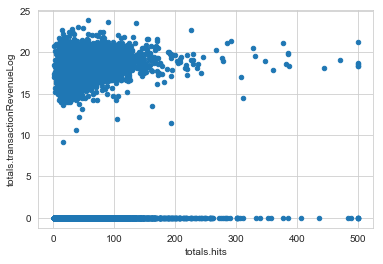

In [345]:

plot = train_flat.plot.scatter('totals.hits', 'totals.transactionRevenueLog')

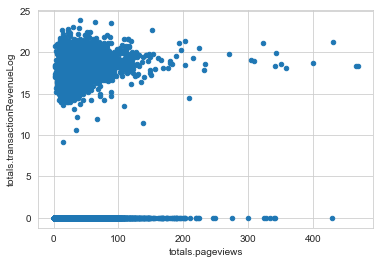

In [346]:

plot = train_flat.plot.scatter('totals.pageviews', 'totals.transactionRevenueLog')

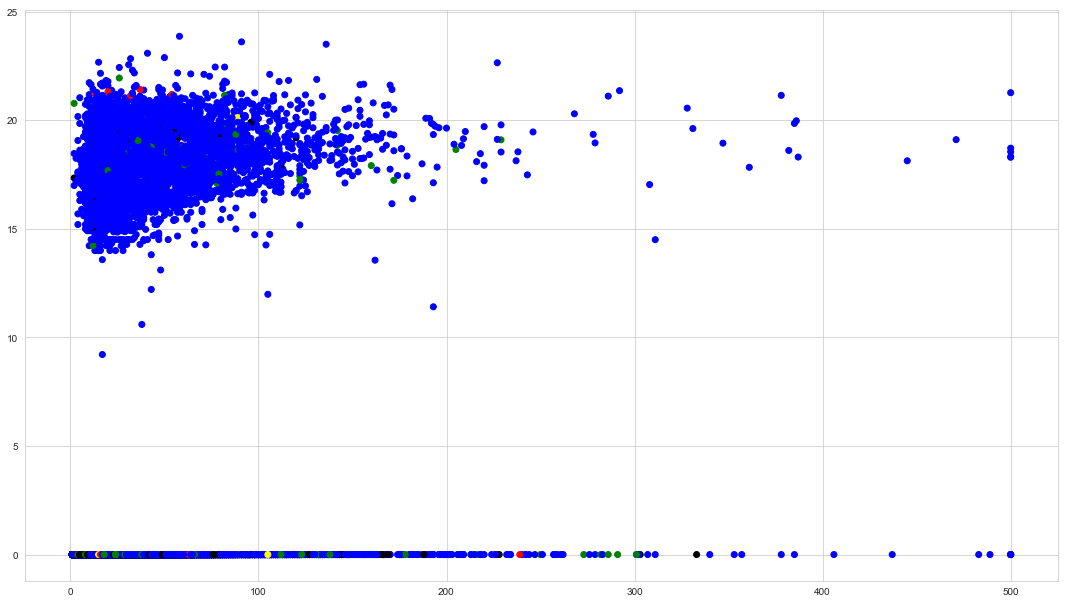

In [347]:
fig, ax = plt.subplots()

colors = {'Africa':'red', 'Americas':'blue', 'Asia':'green', 'Europe':'black', 'Oceania': 'yellow', '(not set)' : 'pink'}

ax.scatter(train_flat['totals.hits'], train_flat['totals.transactionRevenueLog'], c=train_flat['geoNetwork.continent'].apply(lambda x: colors[x]))

fig.set_size_inches(18.5, 10.5)
plt.show()


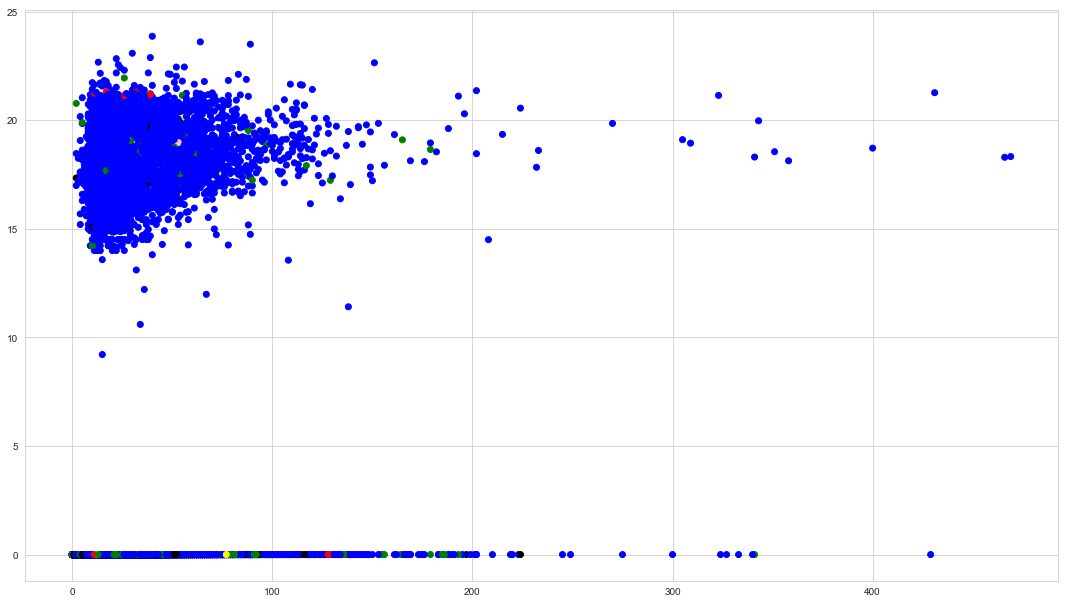

In [348]:
fig, ax = plt.subplots()
colors = {'Africa':'red', 'Americas':'blue', 'Asia':'green', 'Europe':'black', 'Oceania': 'yellow', '(not set)' : 'pink'}
ax.scatter(train_flat['totals.pageviews'], train_flat['totals.transactionRevenueLog'], c=train_flat['geoNetwork.continent'].apply(lambda x: colors[x]))
fig.set_size_inches(18.5, 10.5)
plt.show()

In [349]:

train_flat.info()

train_flat.replace([np.inf, -np.inf], np.nan)

train_flat = train_flat.dropna(subset=['totals.bounces', 'totals.newVisits', 'device.isMobile', 'geoNetwork.networkDomain', 
                 'trafficSource.adwordsClickInfo.page', 'visitStartTime', 'visitNumber', 'geoNetwork.continent', 'geoNetwork.country',
                         'totals.hits', 'totals.pageviews', 'totals.transactionRevenueLog', 'totals.bounces',
                         'totals.newVisits', 'day_of_week', 'week', 'month', 'day', 'year', 'date',
                        'geoNetwork.country'], how='all')




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 34 columns):
channelGrouping                             903653 non-null object
date                                        903653 non-null int64
fullVisitorId                               903653 non-null object
visitId                                     903653 non-null int64
visitNumber                                 903653 non-null int64
visitStartTime                              903653 non-null int64
device.browser                              903653 non-null object
device.deviceCategory                       903653 non-null object
device.isMobile                             903653 non-null bool
device.operatingSystem                      903653 non-null object
geoNetwork.continent                        903653 non-null object
geoNetwork.country                          903653 non-null object
geoNetwork.networkDomain                    903653 non-null object
geoNetwork.region       

In [350]:
train_flat.corr()['totals.transactionRevenueLog'].sort_values()

totals.bounces                        -0.113049
totals.newVisits                      -0.108003
device.isMobile                       -0.046071
day_of_week                           -0.014851
week                                  -0.002743
month                                 -0.002670
day                                   -0.000794
year                                   0.007612
date                                   0.007897
visitId                                0.010491
visitStartTime                         0.010491
trafficSource.adwordsClickInfo.page    0.010931
visitNumber                            0.023666
totals.transactionRevenue              0.315562
totals.hits                            0.378804
totals.pageviews                       0.400732
totals.transactionRevenueLog           1.000000
totals.transactionRevenueLogNAN        1.000000
Name: totals.transactionRevenueLog, dtype: float64

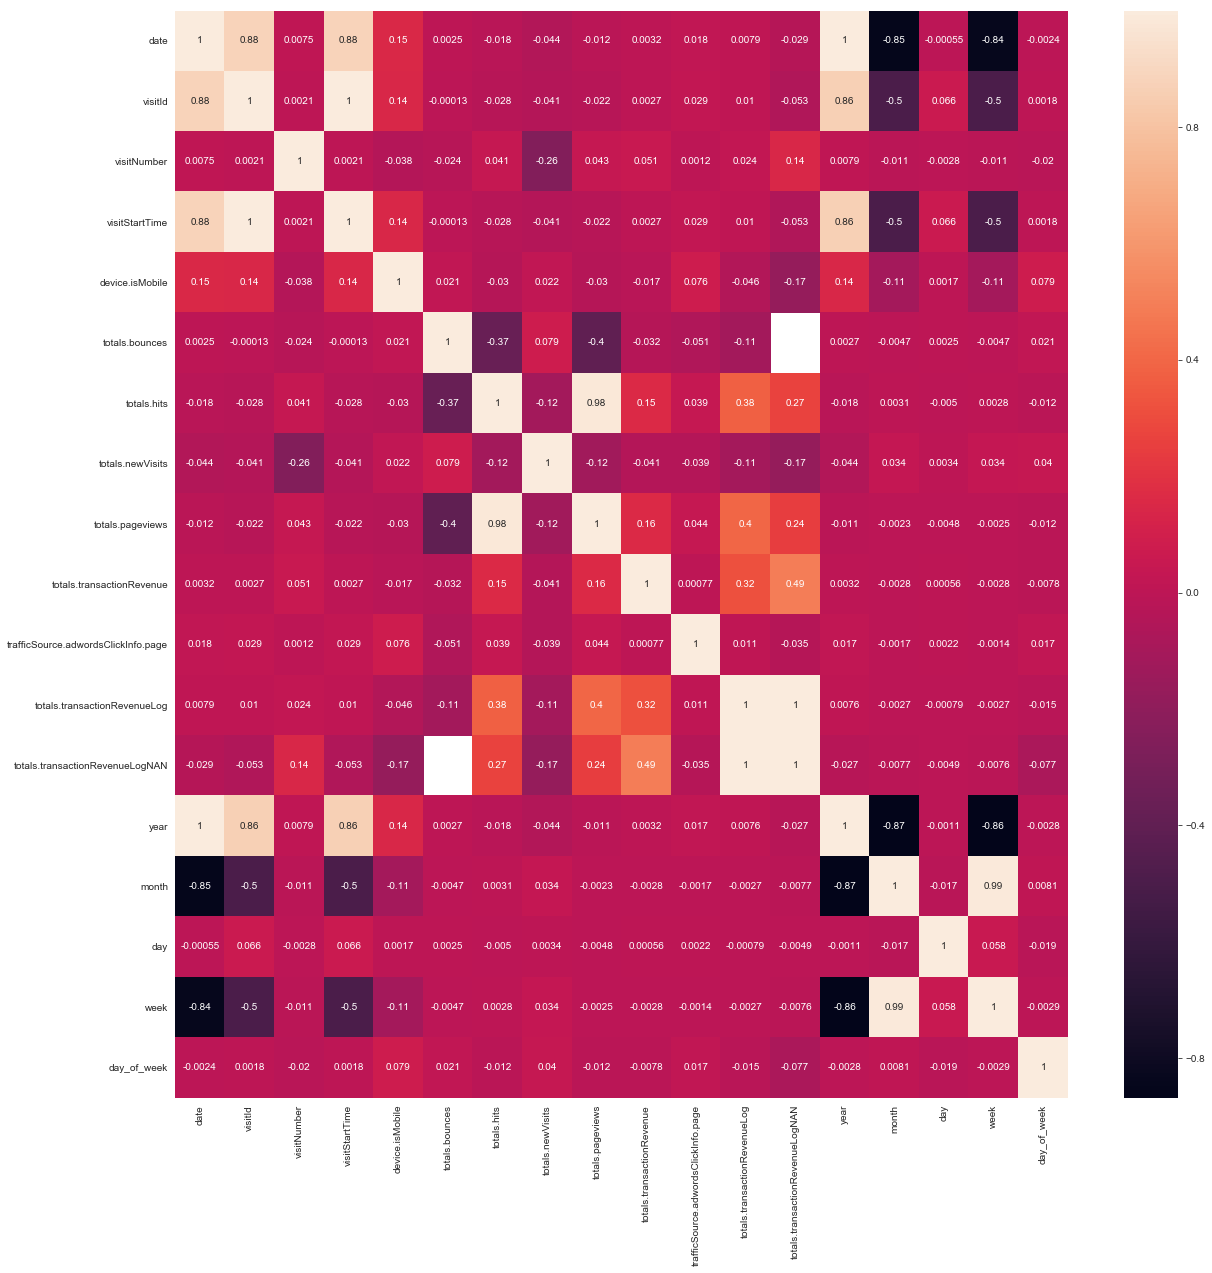

In [351]:
revenue_corr = train_flat.corr()
fig, ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(revenue_corr, annot=True)
plt.show()

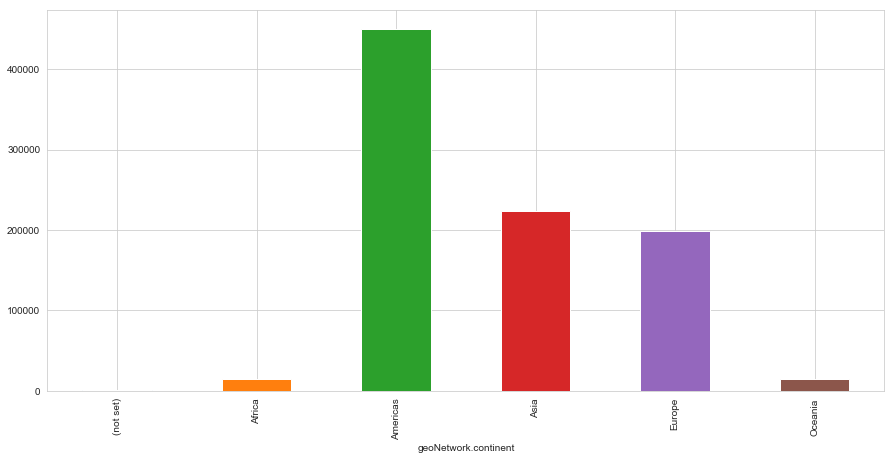

In [352]:
fig, ax = plt.subplots(figsize=(15,7))
train_flat.groupby(['geoNetwork.continent']).count()['totals.transactionRevenueLog'].plot.bar()

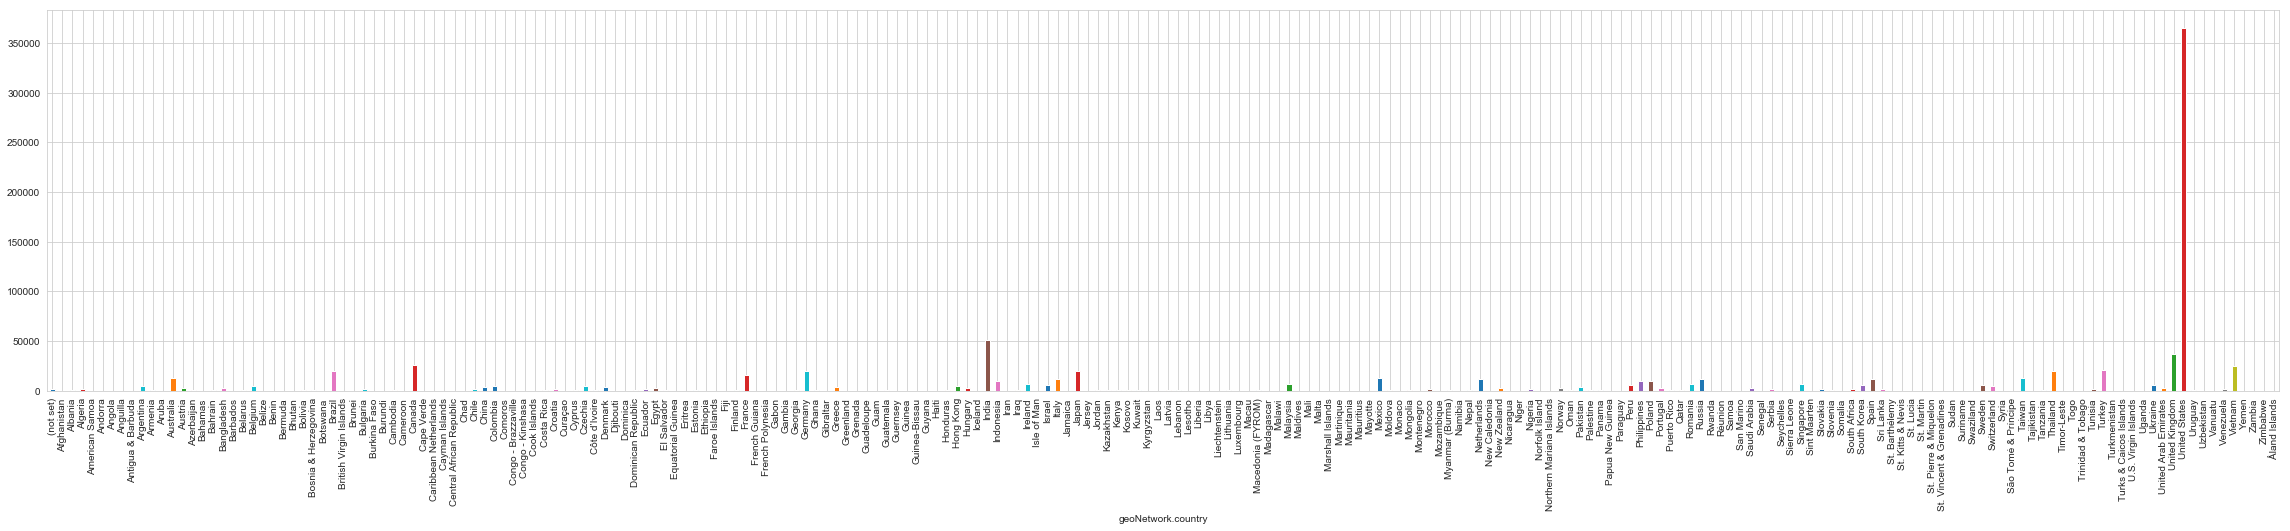

In [353]:
fig, ax = plt.subplots(figsize=(40,7))
train_flat.groupby(['geoNetwork.country']).count()['totals.transactionRevenueLog'].plot.bar()

In [366]:
'''
train_flat.shape
fig, ax = plt.subplots(figsize=(20,10)) 
train_flat["geoNetwork.country"].plot.hist(bins=50)
plt.show()
['equirectangular', 'mercator', 'orthographic', 'natural
            earth', 'kavrayskiy7', 'miller', 'robinson', 'eckert4',
            'azimuthal equal area', 'azimuthal equidistant', 'conic
            equal area', 'conic conformal', 'conic equidistant',
            'gnomonic', 'stereographic', 'mollweide', 'hammer',
            'transverse mercator', 'albers usa', 'winkel tripel',
            'aitoff', 'sinusoidal']
'''

data = dict(type = 'choropleth', 
           locations = train_flat['geoNetwork.country'],
           locationmode = 'country names',
           z = train_flat['totals.transactionRevenue'], 
           text = train_flat['geoNetwork.country'],
           colorbar = {'title':'Transaction Revenue'})
layout = dict(title = 'Happiness Index 2017', 
             geo = dict(showframe = False, 
                       projection = {'type': 'mercator'}))
choromap3 = go.Figure(data = [data], layout=layout)
iplot(choromap3)


In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
train_flat.groupby(['day_of_week']).mean()['totals.transactionRevenueLog'].plot.bar()

In [ ]:
temp_data = train_flat.loc[train_flat['geoNetwork.country'] != 'United States']

fig, ax = plt.subplots(figsize=(15,7))
temp_data.groupby(['device.isMobile']).mean()['totals.transactionRevenueLog'].plot.bar()


In [ ]:
#plot

temp_data = train_flat.loc[train_flat['geoNetwork.country'] == 'United States']
fig, ax = plt.subplots(figsize=(15,7))
temp_data.groupby(['device.isMobile']).mean()['totals.transactionRevenueLog'].plot.bar()

In [ ]:
#populate count map from string values

continent_map = {}
continent_count = 0

country_map = {}
country_count = 0

city_map = {}
city_count = 0

def populate_maps(row):
    global continent_map
    global continent_count

    global country_map
    global country_count

    global city_map
    global city_count
    
    if row['geoNetwork.continent'] not in continent_map:
        continent_count+=1
        continent_map[row['geoNetwork.continent']] = continent_count
        
    if row['geoNetwork.country'] not in country_map:
        country_count+=1
        country_map[row['geoNetwork.country']] = country_count
        
    if row['geoNetwork.networkDomain'] not in city_map:
        city_count+=1
        city_map[row['geoNetwork.networkDomain']] = city_count
        
train_flat.apply (lambda row: populate_maps(row),axis=1)

print("done")

In [ ]:


#drop rows where country is not set
train_flat = train_flat[train_flat['geoNetwork.country'] != '(not set)']



def string_to_int(train_flat):
    global continent_map
    global country_map
    global city_map
    
    train_flat['geoNetwork.networkDomain'] = train_flat['geoNetwork.networkDomain'].map(city_map)
    train_flat['geoNetwork.country'] = train_flat['geoNetwork.country'].map(country_map)
    train_flat['geoNetwork.continent'] = train_flat['geoNetwork.continent'].map(continent_map)

def clean_data(df):
    string_to_int(df)

string_to_int(train_flat)

train_flat.isna().sum()

In [ ]:
def get_input_matrix(train_flat):
    return np.column_stack((train_flat['totals.bounces'], train_flat['totals.newVisits'], 
                            train_flat['device.isMobile'], train_flat['day_of_week'], 
                            train_flat['geoNetwork.country'], train_flat['geoNetwork.continent'], 
                            train_flat['totals.hits'], train_flat['totals.pageviews'], train_flat['visitNumber'],
                           train_flat['geoNetwork.networkDomain']))


train_X = get_input_matrix(train_flat)
train_Y = train_flat['totals.transactionRevenueLog']



cat_cols = [2,3,4,5]
num_cols = ['totals.bounces', 'totals.newVisits', 'device.isMobile', 'day_of_week',
            'geoNetwork.country', 'geoNetwork.continent', 'totals.hits', 'totals.pageviews', 'visitNumber',
            'geoNetwork.networkDomain']

linear_reg_train_X, linear_reg_test_X , linear_reg_train_Y, linear_reg_test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=23)

params = {"early_stopping_rounds":4000, 
           "eval_metric" : 'rmse', 
            "eval_set" : [(train_X, train_Y)],
           'eval_names': ['valid'],
           'verbose': 100,
          'feature_name': num_cols,
         'categorical_feature': cat_cols 
}

# train lgbm model
light_gbm = lgb.LGBMRegressor(num_leaves= 15, 
                         max_depth=-1, 
                         random_state=314, 
                         silent=True, 
                         metric='None', 
                         n_jobs=4, 
                         n_estimators=4000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.1)
bst = light_gbm.fit(train_X, train_Y, **params)

lgbm_predicted_Y = bst.predict(linear_reg_test_X)

#print("Mean squared error: %.5f" % mean_squared_error(linear_reg_test_Y, lgbm_predicted_Y))
#print('Variance: %.5f' % r2_score(linear_reg_test_Y, lgbm_predicted_Y))

lgb.plot_importance(light_gbm)

In [ ]:
string_to_int(test_flat)
test_x = get_input_matrix(test_flat)
lgbm_test_predicted_Y = bst.predict(test_x)

# write prediction to csv file
pred_test_data = pd.DataFrame({"fullVisitorId":test_flat["fullVisitorId"].values})
lgbm_test_predicted_Y[lgbm_test_predicted_Y<0] = 0
pred_test_data["PredictedLogRevenue"] = np.expm1(lgbm_test_predicted_Y)
pred_test_data = pred_test_data.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
pred_test_data.columns = ["fullVisitorId", "PredictedLogRevenue"]
pred_test_data["PredictedLogRevenue"] = np.log1p(pred_test_data["PredictedLogRevenue"])
pred_test_data.to_csv("baseline_lgb.csv", index=False)

In [ ]:


train_flat = train_flat[['totals.bounces', 'totals.newVisits', 'device.isMobile', 'geoNetwork.networkDomain', 
                 'trafficSource.adwordsClickInfo.page', 'visitStartTime', 'visitNumber', 'geoNetwork.continent',
                         'totals.hits', 'totals.pageviews', 'totals.transactionRevenueLog', 'day_of_week', 
                         'week', 'month', 'day', 'year', 'date', 'geoNetwork.country']]
train_flat = train_flat[np.isfinite(train_flat['totals.pageviews'])]




In [ ]:
'''

def get_input_matrix(train_flat):
    return np.column_stack((train_flat['totals.bounces'], train_flat['totals.newVisits'], train_flat['device.isMobile'],
                            train_flat['geoNetwork.networkDomain'], train_flat['day_of_week'], train_flat['week'], 
                            train_flat['month'], train_flat['day'], train_flat['year'], train_flat['date'], 
                            train_flat['visitStartTime'], train_flat['trafficSource.adwordsClickInfo.page'], 
                            train_flat['visitNumber'], train_flat['geoNetwork.country'], train_flat['geoNetwork.continent'], 
                            train_flat['totals.hits'], train_flat['totals.pageviews']))


train_X = get_input_matrix(train_flat)
train_Y = train_flat['totals.transactionRevenueLog']

linear_reg_train_X, linear_reg_test_X , linear_reg_train_Y, linear_reg_test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=23)

# Linear Regression model initialization (basic)
zillow_linear_regression = LinearRegression()

# Training the Linear Regression Model
zillow_linear_regression.fit(linear_reg_train_X, linear_reg_train_Y)

# Using the model to predict the test dataset
linear_reg_predicted_Y = zillow_linear_regression.predict(linear_reg_test_X)

# The coefficients of the linear equation aX1 + bX2 + cX3 + ... = Y
print('Coefficients (a,b,c,..) : ', [(x,y) for x,y in zip(train_X,zillow_linear_regression.coef_)])

# The mean squared error of the linear regression model's predictions
print("Mean squared error: %.5f" % mean_squared_error(linear_reg_test_Y, linear_reg_predicted_Y))

# Variance of the prediction
print('Variance : %.5f' % r2_score(linear_reg_test_Y, linear_reg_predicted_Y))

'''

In [ ]:
'''
from sklearn.svm import SVR

# Initializing the KNN object with the epsilon (error penalizing factor) to 0.05
# This value was experimented on using cross validation dataset and the analysis
# resulted in the model performing better for lower values
zillow_svm = SVR(C=1.0, epsilon=0.05)

# Spliting the dataset into train and test data
svm_train_X, svm_cross_valid_X , svm_train_Y, svm_cross_valid_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=12)

# Training the SVM
zillow_svm.fit(svm_train_X, svm_train_Y)

# Using the model to predict the test dataset
svm_predicted_Y = zillow_svm.predict(svm_cross_valid_X)

# The mean squared error of the SVM model's prediction
print("Mean squared error: %.5f" % mean_squared_error(svm_cross_valid_Y, svm_predicted_Y))

# Variance of the prediction
print('Variance : %.5f' % r2_score(svm_cross_valid_Y, svm_predicted_Y))
'''